In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree
import seaborn

### Calculating distances

`SuchTree` has two ways approaches for calculating distances. One pair a time, or
several large groups of pairs at once. The large groups is more efficient because
it does each calculation without the interpreter's overhead.

In [3]:
T = SuchTree( 'SuchTree/tests/test.tree')

In [4]:
D1 = zeros( ( len(T.leafs),len(T.leafs) ) )
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )

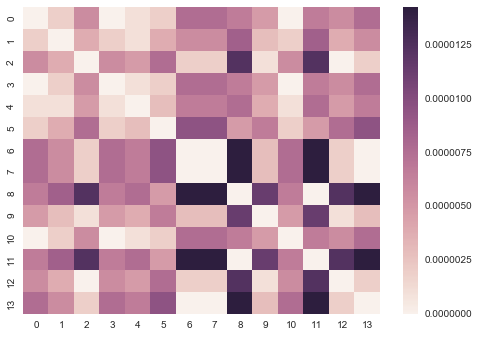

In [5]:
seaborn.heatmap(D1)

In [6]:
D2_list = []
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )
D2 = T.distances( D2_array )
D2 = D2.reshape( ( len(T.leafs), len(T.leafs) ) )

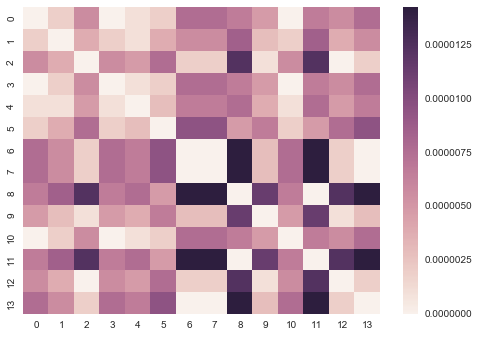

In [7]:
seaborn.heatmap(D2)

### Comparing the topologies of two large trees

Here, we use `SuchTree` to compare the topology of a two trees containing the taxa
but constructe with different methods ([`FastTree`](http://www.microbesonline.org/fasttree/) and 
[`Neighbor_joining`](https://en.wikipedia.org/wiki/Neighbor_joining)). One million random pairs are 
sampled from each tree, and the distances compared.

On my [rather elderly laptop](https://en.wikipedia.org/wiki/ThinkPad_X_Series#X200s), 
the distance calculations in both trees are completed in 5.46 seconds (most of which
is mapping the names to the node indicies).

In [4]:
!wget http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree
!wget http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree

--2016-05-04 03:55:38--  http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree
Resolving edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)... 128.120.243.81
Connecting to edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)|128.120.243.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2076866 (2.0M)
Saving to: ‘fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree’

fishpoo2_p200_c2_un 100%[=====================>]   1.98M  2.96MB/s   in 0.7s   

2016-05-04 03:55:39 (2.96 MB/s) - ‘fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree’ saved [2076866/2076866]

--2016-05-04 03:55:39--  http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree
Resolving edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)... 128.120.243.81
Connecting to edhar.genomecenter.ucdavis.edu (edhar.genomecenter.ucdavis.edu)|128.120.243.81|:80... connected.
HTTP requ

In [3]:
T1 = SuchTree( 'fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
T2 = SuchTree( 'fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree' )

In [4]:
len(T1.leafs), len(T2.leafs)

(54327, 54327)

In [8]:
import random

N = 1000000

v = T1.leafs.keys()

pairs = []
for i in range(N) :
    pairs.append( ( random.choice( v ), random.choice( v ) ) )

%time D1 = T1.distances_by_name( pairs ); D2 = T2.distances_by_name( pairs )

CPU times: user 5.38 s, sys: 64 ms, total: 5.44 s
Wall time: 5.46 s


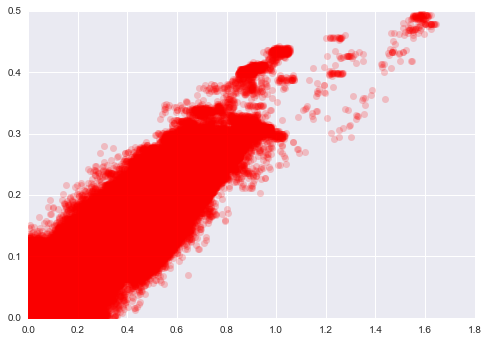

In [9]:
plot( D1, D2, 'ro', alpha=0.2 )

In [10]:
from scipy.stats import kendalltau, pearsonr

print kendalltau( D1, D2 )
print pearsonr( D1, D2 )

KendalltauResult(correlation=0.76280303464919186, pvalue=0.0)
(0.94873300817106465, 0.0)
